In [0]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 217.8MB 62kB/s 
     |████████████████████████████████| 204kB 47.5MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=e653f6430443b64e3e76eaa48a43f0de9989eb45213df7d0225ca232630543ad
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark
openjdk-8-jdk-headless is already the newest version (8u242-b08-0ubuntu3~18.04).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [0]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2020-04-30 20:41:54--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.54.211.101, 3.229.178.204, 34.196.12.177, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.54.211.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  6.49MB/s    in 2.0s    

2020-04-30 20:41:56 (6.49 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range


Loading datasets

In [0]:
c1 = np.genfromtxt("c1.txt")
c2 = np.genfromtxt("c2.txt")
data = sc.textFile("data.txt",8)

In [0]:
data_1 = data.map(lambda x:(x.split(' ')))
data_parsed = data_1.map(lambda lines: [float(x) for x in lines])

In [0]:
data_parsed.take(2)

Defining UDF for euclidean and manhattan distance calculation and cost function computation

In [0]:
def euclideanDist(a,b):
  return np.linalg.norm(a-b, axis = 1)

In [0]:
def manhattanDist(a,b):
  return cdist([a], b, metric='cityblock')

In [0]:
def euclideanCost(a,b):
  e_dist = euclideanDist(a,b)
  return np.argmin(e_dist), np.min(e_dist)



In [0]:
def manhattanCost(a,b):
  m_dist = manhattanDist(a,b)
  return np.argmin(m_dist), np.min(m_dist)


In [0]:
def compute_k_means(data, Centroinds, max_iters, method):


  cost_history = []
  C = Centroinds
  if method == 'euclidean':
    func = euclideanCost
  elif method == 'manhattan':
    func = manhattanCost
  else:
    return print("Wrong method input| Choose one of these methods: euclidean|manhattan")

  for k in range(max_iters):
    clusters_map = data.map(lambda p: (func(p, C), p)).map(lambda p: (p[0][0], p[1]))
    min_dist_map = data.map(lambda p: (func(p, C), p)).map(lambda p: (p[1], p[0][1]))
    cost = 0
    for points in min_dist_map.collect():
      if method == 'euclidean':
        cost += points[1]**2
      elif method == 'manhattan':
        cost += points[1]

    cost_history.append(cost)

    C = clusters_map.groupByKey().map(lambda c: np.mean([x for x in c[1]], 0)).collect()
    C = np.array(C)

  return cost_history

In [0]:
def computeCostChange(cost, i = 0, k = 10):
  change = (cost[i]-cost[k])/cost[i]
  return change


RUn K-means for the two sets of centroids C1 and C2 using euclidean distance method

In [0]:
cost_c1 = compute_k_means(data_parsed, c1, max_iters = 20, method = "euclidean")
cost_c2 = compute_k_means(data_parsed, c2, max_iters = 20, method = "euclidean")

Text(0.5, 1.0, 'C2 centroids')

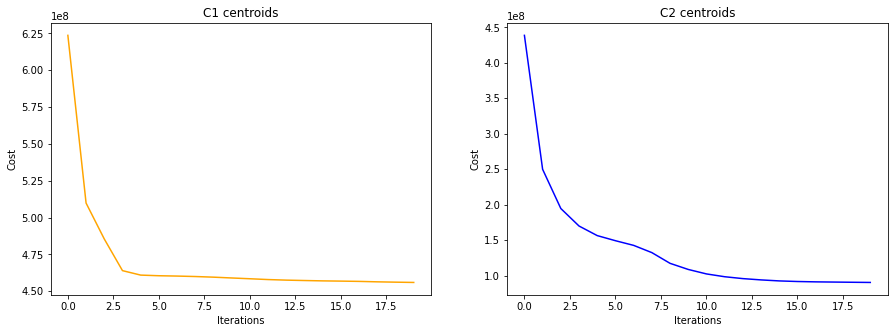

In [150]:
#plotting the cost function vs iteration graph for the two centroids
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.plot(cost_c1, color = "orange", label = "C1 centroids")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("C1 centroids")

plt.subplot(1,2,2)
plt.plot(cost_c2, color = "blue", label = "C2 centroids")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("C2 centroids")

In [175]:
c1_change = computeCostChange(cost_c1)
print("For C1 centroids, cost reduced by ", int((c1_change)*100), "%")

c2_change = computeCostChange(cost_c2)
print("For C2 centroids, cost reduced by ", int((c2_change)*100), "%")

For C1 centroids, cost reduced by  26 %
For C2 centroids, cost reduced by  76 %


Run K-means for the two sets of centroids C1 and C2 using manhattan distance method

In [0]:
cost_c1 = compute_k_means(data_parsed, c1, max_iters = 20, method = "manhattan")
cost_c2 = compute_k_means(data_parsed, c2, max_iters = 20, method = "manhattan")

Text(0.5, 1.0, 'C2 centroids')

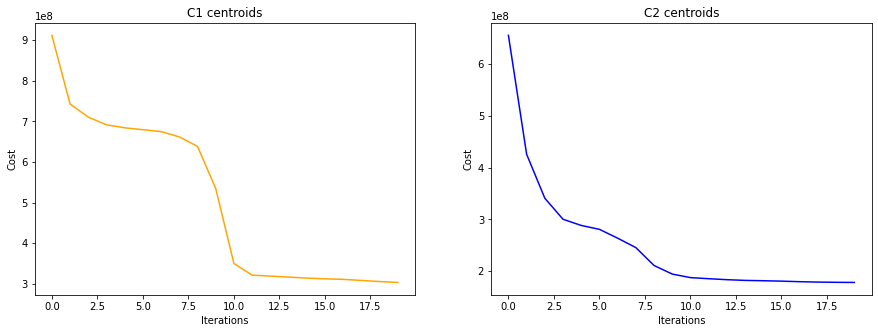

In [177]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.plot(cost_c1, color = "orange", label = "C1 centroids")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("C1 centroids")

plt.subplot(1,2,2)
plt.plot(cost_c2, color = "blue", label = "C2 centroids")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("C2 centroids")

In [178]:
c1_change = computeCostChange(cost_c1)
print("For C1 centroids, cost reduced by ", int((c1_change)*100), "%")

c2_change = computeCostChange(cost_c2)
print("For C2 centroids, cost reduced by ", int((c2_change)*100), "%")

For C1 centroids, cost reduced by  61 %
For C2 centroids, cost reduced by  71 %
